In [1]:
import os
import cv2
import random
import zipfile
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from matplotlib.patches import Rectangle
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split

In [173]:
#parsing xml annotation to crop the characters from the image using bboxes dimensions
def annotations(filepath):
    for dir in os.listdir(filepath):
        if os.path.isdir(os.path.join(filepath,dir)):
            count = 0
            for file in os.listdir(os.path.join(filepath,dir)): 
                if file.endswith("xml"):
                    tree = ET.parse(os.path.join(filepath,dir,file))
                    root = tree.getroot()
                    im = Image.open(os.path.join(filepath,dir,root[1].text))
                    for obj in root.iter('object'):
                        if os.path.isdir(os.path.join(filepath,dir,obj[0].text)):
                            pass    
                        else:
                            os.mkdir(os.path.join(filepath,dir,obj[0].text))
                        (left, right, top, bottom) = (obj[5][0].text, obj[5][1].text, obj[5][3].text, obj[5][2].text)
                        im_copy = im.crop((int(left), int(bottom), int(right), int(top)))
                        im_copy.save(f"{os.path.join(filepath,dir,obj[0].text,str(count))}"+".jpg")
                        count = count+1                        
                    im.close()

In [163]:
annotations(f'D:\COMP303\Pascal VOC\Doctor Handwriting.v3i.voc')

In [4]:
path = f"../handwriting/data"
xtrain = np.zeros((4069, 1024, 3), dtype=float)
ytrain = np.zeros(4069, dtype=int)
i=0
classes = 0
for dir in os.listdir(path):
    for imgs in os.listdir(path+'/'+dir):
        org_img = tf.keras.preprocessing.image.load_img(path+'/'+dir+'/'+imgs).resize((32,32))
        org_img_to_array = tf.keras.preprocessing.image.img_to_array(org_img)
        reshaped_img = org_img_to_array.reshape(-1,3)/255.0
        xtrain[i,:,:] = reshaped_img
        ytrain[i] = classes
        i=i+1
    classes = classes+1
print('writing to the file')

with open('../handwriting/xtrain.npy','wb') as f:
    np.save(f,xtrain)
with open('../handwriting/ytrain.npy', 'wb') as f:
    np.save(f, ytrain)

writing to the file


In [49]:
with open('../handwriting/xtrain.npy','rb') as f:
    x = np.load('../handwriting/xtrain.npy')
with open('../handwriting/ytrain.npy', 'rb') as f:
    y =np.load('../handwriting/ytrain.npy')

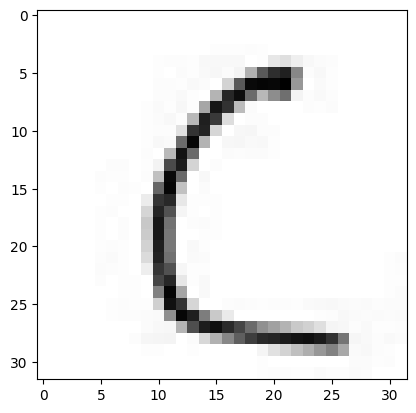

In [6]:
first = tf.keras.preprocessing.image.array_to_img(x[0].reshape(32,32,3))
plt.imshow(first)

In [7]:
y.shape

(4069,)

In [50]:
X_train, X_, y_train, y_ = train_test_split(x, y, random_state=False, test_size=0.2, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, random_state=False, test_size=0.5, shuffle=True)

vgg = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=(32, 32, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = tf.keras.layers.Flatten()(flatten)
labelHead = tf.keras.layers.Dense(128, activation="relu")(flatten)
labelHead = tf.keras.layers.Dense(64, activation="relu")(labelHead)
labelHead = tf.keras.layers.Dense(32, activation="relu")(labelHead)
labelHead = tf.keras.layers.Dense(23, activation="softmax")(labelHead)
model = tf.keras.Model(inputs=vgg.input, outputs=labelHead)

model.compile(
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'],
              optimizer='adam'
             )

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3)

In [12]:
history = model.fit(X_train.reshape(-1,32,32,3),y_train,epochs=100,batch_size=16,validation_data=(X_val.reshape(-1,32,32,3),y_val), callbacks=[callback])

Epoch 1/100
204/204 [==============================] - 41s 38ms/step - loss: 1.4559 - acc: 0.6449 - val_loss: 0.5644 - val_acc: 0.8919
Epoch 2/100
204/204 [==============================] - 6s 28ms/step - loss: 0.4099 - acc: 0.9250 - val_loss: 0.2696 - val_acc: 0.9558
Epoch 3/100
204/204 [==============================] - 6s 28ms/step - loss: 0.2567 - acc: 0.9499 - val_loss: 0.2318 - val_acc: 0.9607
Epoch 4/100
204/204 [==============================] - 6s 29ms/step - loss: 0.1976 - acc: 0.9641 - val_loss: 0.2356 - val_acc: 0.9681
Epoch 5/100
204/204 [==============================] - 6s 29ms/step - loss: 0.1600 - acc: 0.9751 - val_loss: 0.2440 - val_acc: 0.9631
Epoch 6/100
204/204 [==============================] - 6s 28ms/step - loss: 0.1345 - acc: 0.9770 - val_loss: 0.2203 - val_acc: 0.9754
Epoch 7/100
204/204 [==============================] - 6s 27ms/step - loss: 0.1103 - acc: 0.9819 - val_loss: 0.2326 - val_acc: 0.9730
Epoch 8/100
204/204 [==============================] - 6s 28m

In [13]:
model.save('../models/ocr.h5',overwrite=True)

In [51]:
model = tf.keras.models.load_model('../models/ocr.h5')

In [52]:
labelNames = os.listdir('../handwriting/data/')
print(labelNames)

['-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'P', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z']


1/1 [==============================] - 0s 16ms/step


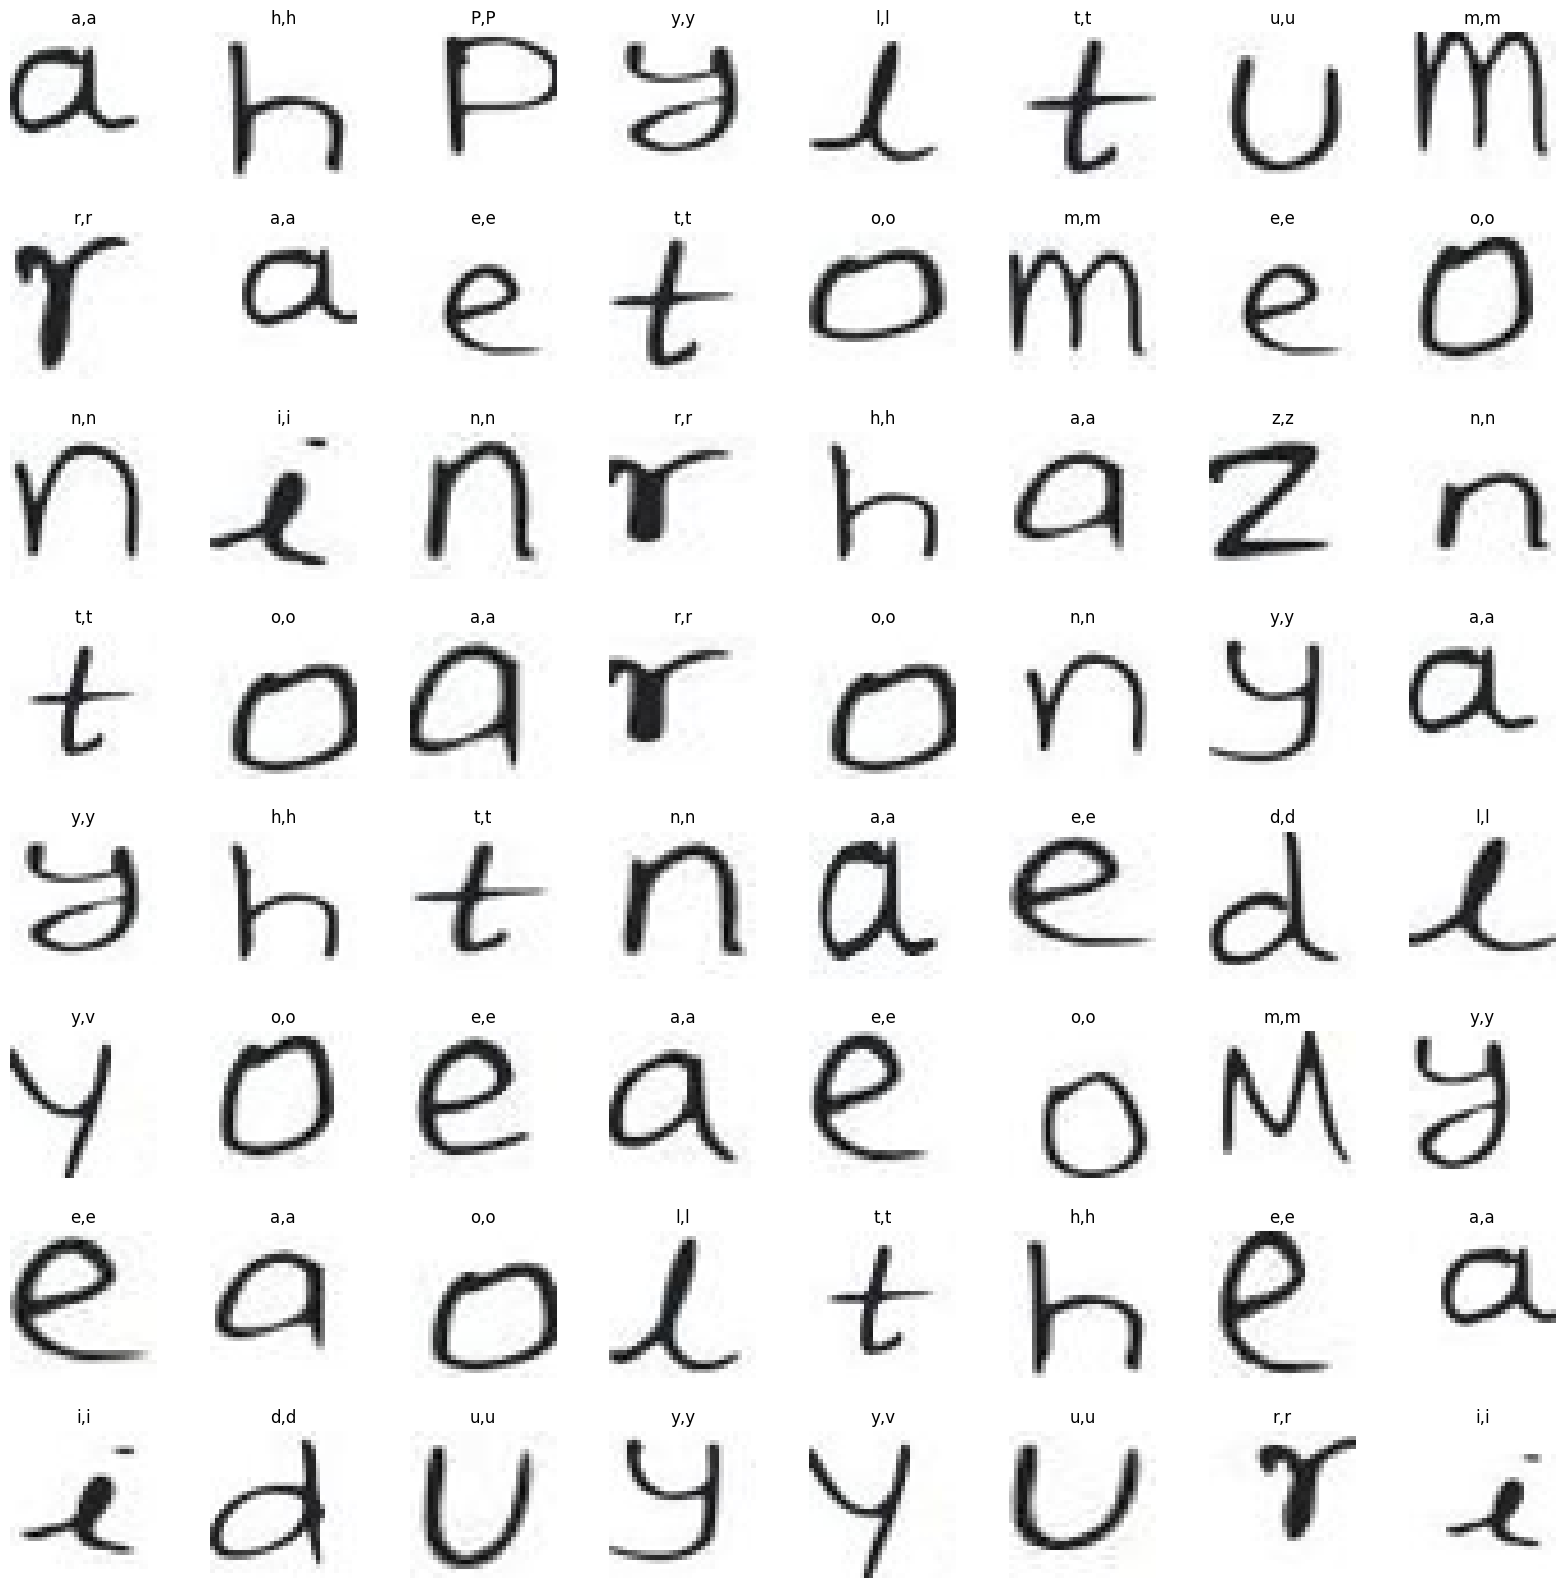

In [54]:
fig,axes = plt.subplots(8,8,figsize=(16,16))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    randomindex = np.random.randint(150)
    prediction = model.predict(X_test[randomindex].reshape(-1,32,32,3))
    X_random = X_test[randomindex].reshape(32,32,3)
    ax.imshow(X_random,cmap="gray")
    ax.set_title(f"{labelNames[y_test[randomindex]]},{labelNames[np.argmax(prediction)]}")
    ax.set_axis_off()
plt.savefig("../handwriting/test.png")

In [55]:
y_pred = np.zeros((407,))
test_classes = []

for i in range(407):
    prediction = model.predict(X_test[i].reshape(-1,32,32,3))
    value = np.argmax(prediction)
    if labelNames[value] not in test_classes:
        test_classes.append(labelNames[value])
    y_pred[i] = value

1/1 [==============================] - 0s 16ms/step


In [7]:
test_classes

['i',
 'r',
 'a',
 'x',
 'm',
 'u',
 't',
 'e',
 'y',
 '-',
 'd',
 'l',
 'o',
 'n',
 'b',
 'h',
 's',
 'c',
 'P',
 'v',
 'z',
 'f']

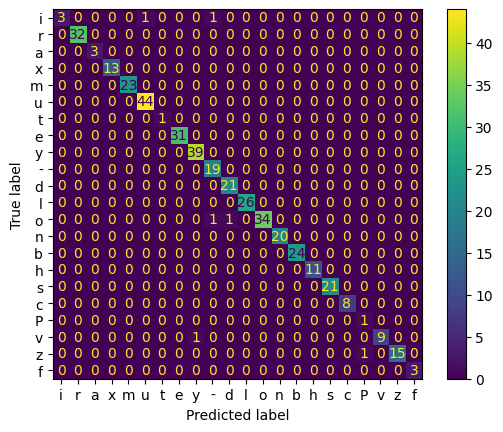

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_classes)
display.plot()
plt.savefig('../handwriting/confusion_matrix.png')

In [57]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return cnts, boundingBoxes

In [58]:
def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts

In [59]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

In [42]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread("../handwriting/train/Insulin.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

In [43]:
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = resize(thresh, height=32)
   	# re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [44]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

In [45]:
rgb_img = np.array([img_to_array(Image.fromarray(chars[a],mode='RGB')) for a in range(0,chars.shape[0])]) 
prediction = model.predict(rgb_img,batch_size=rgb_img.shape[0])

1/1 [==============================] - 0s 359ms/step


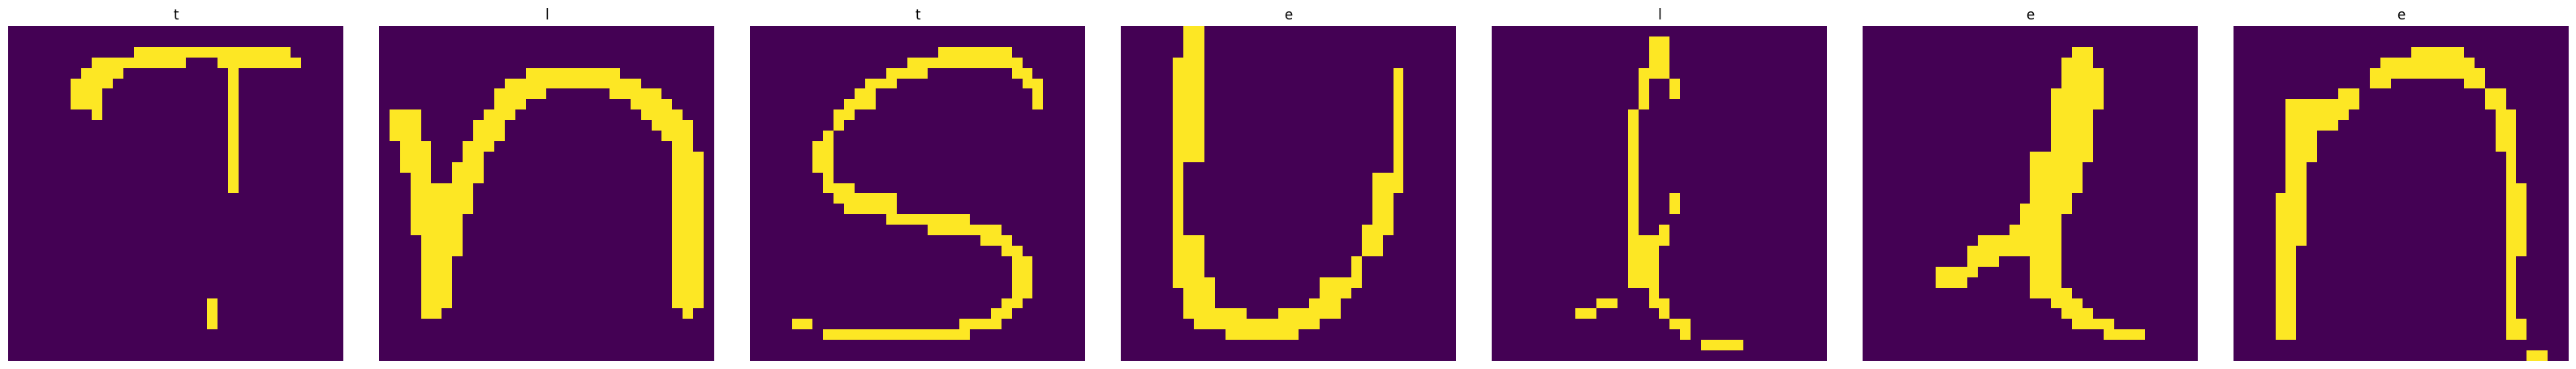

In [46]:
fig,axes = plt.subplots(1,chars.shape[0],figsize=(32,32))
fig.tight_layout(pad=0.1)
i = 0
for _,ax in enumerate(axes.flat): 
    ax.imshow(chars[i].astype(np.uint8))
    ax.set_title(f"{labelNames[np.argmax(prediction[i])]}")
    ax.set_axis_off()
    i = i+1

In [47]:
predicted_text = ""
for (pred,(x,y,w,h)) in zip(prediction,boxes):
    i = np.argmax(pred)
    prob = pred[i]
    predicted_text += labelNames[i]
print(predicted_text)

tltelee
